# **Develop Regression Models for Soil Properties Estimation**

In [1]:
from tensorflow.python.client import device_lib
print("GPU sample processing: ")
print(device_lib.list_local_devices())

GPU sample processing: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11364785496247528926
]


In [2]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

### Load data

In [3]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data_remove_class_5.csv')
tb_data_path = os.path.join(DATA_DIR, '210507 TB (Blue) data_(PDF and CAD).csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

### Data pre-processing

In [4]:
# Specific soil types
assign_num_list = {
                    'topsoil layer': 7,
                    'reclaimed layer': 6,
                    'sedimentary layer': 5,
                    'weathered soil': 4,
                    'weathered rock': 3,
                    'soft rock': 2,
                    'moderate rock': 1,
                     'hard rock': 0,
                  }

In [5]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X1(CAD)','Y1(CAD)','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalized_X_train_ntb = normalizer.fit_transform(X_train_ntb)
normalized_X_train_tb = normalizer.fit_transform(X_train_tb)

# merge NTB and TB
X_train_merged_ntb_tb = np.concatenate((X_train_ntb, X_train_tb), axis=0)
normalized_X_merged_ntb_tb = np.concatenate((normalized_X_train_ntb, normalized_X_train_tb), axis=0)
y_train_merged_ntb_tb = np.concatenate((y_train_ntb, y_train_tb), axis=0)


In [6]:
ntb_data

,Name,X,Y,Elevation,Soi properties (main),Unnamed: 5,Update evlevation,Elevation past,Target
0,NTB-1,549723.89,213802.88,128.5,reclaimed layer,NaN,128.5,28.5,6
1,NTB-1,549723.89,213802.88,126.0,sedimentary layer,NaN,126.0,26.0,5
2,NTB-1,549723.89,213802.88,121.5,weathered soil,NaN,121.5,21.5,4
3,NTB-1,549723.89,213802.88,107.7,weathered rock,NaN,107.7,7.7,3
4,NTB-1,549723.89,213802.88,99.7,soft rock,NaN,99.7,-0.3,2
...,...,...,...,...,...,...,...,...,...
90,NTB-12,549564.60,213804.70,114.5,weathered rock,NaN,114.5,14.5,3
91,NTB-12,549564.60,213804.70,107.5,moderate rock,NaN,107.5,7.5,1
92,NTB-12,549564.60,213804.70,89.5,hard rock,NaN,89.5,-10.5,0
93,NTB-12,549564.60,213804.70,86.5,moderate rock,NaN,86.5,-13.5,1


In [7]:
tb_data

,Name,X,Y,Elevation,Soi properties (main),Unnamed: 5,Unnamed: 6,X1(CAD),Y1(CAD),Target
0,TB-1,549699.0411,213765.3279,128.60,reclaimed layer,NaN,NaN,549699.0411,213765.3279,6
1,TB-1,549699.0411,213765.3279,126.60,sedimentary layer,NaN,NaN,549699.0411,213765.3279,5
2,TB-1,549699.0411,213765.3279,117.60,weathered soil,NaN,NaN,549699.0411,213765.3279,4
3,TB-1,549699.0411,213765.3279,108.10,weathered rock,NaN,NaN,549699.0411,213765.3279,3
4,TB-1,549699.0411,213765.3279,94.60,soft rock,NaN,NaN,549699.0411,213765.3279,2
...,...,...,...,...,...,...,...,...,...,...
111,TB-22,550622.5600,213730.7000,134.49,reclaimed layer,NaN,NaN,550626.9000,213737.3069,6
112,TB-22,550622.5600,213730.7000,114.19,weathered soil,NaN,NaN,550626.9000,213737.3069,4
113,TB-22,550622.5600,213730.7000,104.19,weathered rock,NaN,NaN,550626.9000,213737.3069,3
114,TB-22,550622.5600,213730.7000,93.69,soft rock,NaN,NaN,550626.9000,213737.3069,2


# Deterministic Models

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Deep regression neural network 

In [9]:
def create_model(dim):
    model = Sequential([
        Dense(32, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(16, activation = 'relu', kernel_initializer='he_normal'),
        Dense(8, activation = 'relu', kernel_initializer='he_normal'),
        Dense(1, kernel_initializer='he_normal', activation='linear')
    ])
    
    model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=0.001))
    
    model.summary()
    return model

### Customized callbacks

In [10]:
def get_checkpoint_best_only(model_type = 'deterministic', train_data = 'ntb'):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}_{}/checkpoint".format(model_type, train_data)

    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = "epoch",
                                save_weights_only = True,
                                monitor = "mean_squared_error",
                                save_best_ony = True,
                                verbose = 1)
    return checkpoint

In [11]:
def get_early_stopping():
    early_stopping = EarlyStopping(monitor = "loss", mode ="min", patience = 5)
    return early_stopping 
    

In [12]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'deterministic', train_data = 'ntb')
early_stopping = get_early_stopping()

In [13]:
callbacks = [checkpoint_best_only, early_stopping]

In [14]:
model = create_model(dim = 3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


### **Train on NTB**

In [15]:
%%time
hist = model.fit(normalized_X_train_ntb, y_train_ntb, 
                epochs = 500, verbose=1,
                batch_size=16,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/500
6/6 [==============================] - 0s 729us/step - loss: 10.6054

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 2/500
6/6 [==============================] - 0s 701us/step - loss: 11.0359

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 3/500
6/6 [==============================] - 0s 783us/step - loss: 8.5925

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 4/500
6/6 [==============================] - 0s 730us/step - loss: 8.0966

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 5/500
6/6 [==============================] - 0s 715us/step - loss: 7.5564

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministi

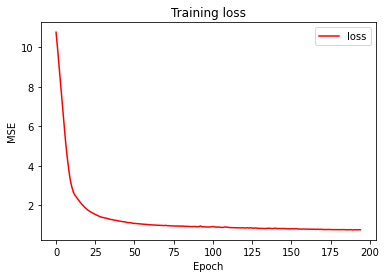

In [16]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


### **Train on TB**

In [17]:
model = create_model(dim = 3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'deterministic', train_data = 'tb')
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [19]:
%%time
hist = model.fit(normalized_X_train_tb, y_train_tb, 
                epochs = 500, verbose=1,
                batch_size=16,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/500
8/8 [==============================] - 0s 618us/step - loss: 18.1173

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 2/500
8/8 [==============================] - 0s 710us/step - loss: 17.3798

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 3/500
8/8 [==============================] - 0s 634us/step - loss: 12.9065

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 4/500
8/8 [==============================] - 0s 691us/step - loss: 11.6288

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 5/500
8/8 [==============================] - 0s 665us/step - loss: 9.1097

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_

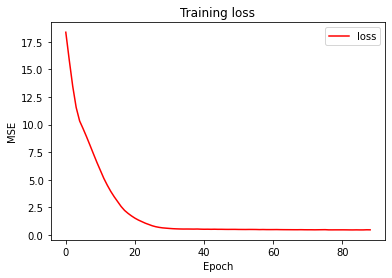

In [20]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### **Train on merged NTB and TB**

In [21]:
model = create_model(dim = 3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'deterministic', train_data = 'merged_ntb_tb')
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [23]:
%%time
hist = model.fit(normalized_X_merged_ntb_tb, y_train_merged_ntb_tb, 
                epochs = 500, verbose=1,
                batch_size=16,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/500
14/14 [==============================] - 0s 592us/step - loss: 16.0643

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 2/500
14/14 [==============================] - 0s 606us/step - loss: 12.8901

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 3/500
14/14 [==============================] - 0s 554us/step - loss: 8.9231

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 4/500
14/14 [==============================] - 0s 676us/step - loss: 7.4003

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 5/500
14/14 [==============================] - 0s 733us/step - loss: 5.3125

Epoch 00005: saving model to /home/daitran/Desktop/git/

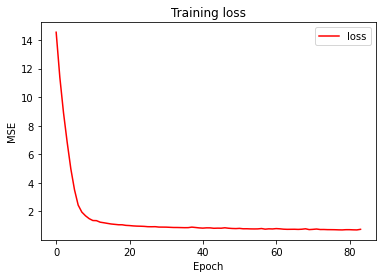

In [24]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Probabilistic models

In the deterministic models, we develop ANN's weights with a single value. However, the true value of this weight is not certion. Because we have too little data points, therefor the training data contains its uncertainty. So, we have to develop the model that can handle the uncertainty in deep learning models. This is done by changing each weight from a single deterministic value to a probability distribution.

### Baysian Neural Network

In [25]:
# tfd = tfp.distributions
# tfpl = tfp.layers

In [26]:
# def prior(kernel_size, bias_size, dtype = None):
#     n = kernel_size + bias_size
#     prior_model = Sequential([
#         tfpl.DistributionLambda(
#             lambda t : tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n))
#         )
#     ])
#     return prior_model

In [27]:
# def posterior(kernel_size, bias_size, dtype = None):
#     n = kernel_size + bias_size
#     posterior_model = Sequential([
#         tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
#         tfpl.MultivariateNormalTriL(n)
#     ])
#     return posterior_model

In [28]:
# model_prob = Sequential([
#     tfpl.DenseVariational(units=20,
#                           input_shape=(3,),
#                           make_prior_fn=prior,
#                           make_posterior_fn=posterior,
#                           kl_weight=1/normalized_X_train_ntb.shape[0],
#                           activation='relu'),
#     tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
#                           make_prior_fn=prior,
#                           make_posterior_fn=posterior,
#                           kl_weight=1/normalized_X_train_ntb.shape[0]),
#     tfpl.IndependentNormal(1)
# ])

In [29]:
# def nll(y_true, y_pred):
#     return -y_pred.log_prob(y_true)

# model_prob.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=0.001))
# model_prob.summary()

In [30]:
# normalized_X_train_ntb_d =  tf.constant(normalized_X_train_ntb, dtype=tf.float64)

In [31]:
# tf.dtypes.cast(normalized_X_train_ntb_d, tf.float64)

In [32]:
# y_train_ntb_d =  tf.constant(y_train_ntb, dtype=tf.float64)

In [33]:
# tf.dtypes.cast(y_train_ntb_d, tf.float64)

In [34]:
# tf.config.run_functions_eagerly(True)

In [35]:
# checkpoint_best_only = get_checkpoint_best_only(model_type = 'probabilistic')
# callbacks_prob = [checkpoint_best_only]

### Train

In [36]:
# his_prob = model_prob.fit(normalized_X_train_ntb_d, y_train_ntb_d,
#                      epochs=100, verbose=1,
# #                      batch_size = 10,
#                      callbacks=callbacks_prob
#                          )

In [37]:
# plt.plot(his_prob.history['loss'],'r',label='loss')
# # plt.plot(hist.history['val_loss'],'b',label='val_loss')
# plt.legend()
# plt.show()


## **Predict**

In [38]:
def get_model_best_epoch(model, model_type, train_data = 'ntb'):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}_{}/checkpoint".format(model_type, train_data)
    
    model.load_weights(checkpoint_path)
    
    return model

In [39]:
max_x = np.max(X_train_merged_ntb_tb[:,0])
max_y = np.max(X_train_merged_ntb_tb[:,1])

min_x = np.min(X_train_merged_ntb_tb[:,0])
min_y = np.min(X_train_merged_ntb_tb[:,1])

In [40]:
def plot_data(x, y, labels, colours):
    
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(20, 10))
    
    ax = fig.add_subplot(121, projection='3d')

    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        plt.xlim([min_x, max_x])
        plt.ylim([min_y, max_y])
        ax.set_zlim(80, 140)
        
    ax = fig.add_subplot(122, projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        ax.view_init(90, 0)   
        plt.xlim([min_x, max_x])
        plt.ylim([min_y, max_y])
        ax.set_zlim(80, 140)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

In [41]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [42]:
label_colours = ['black', 'brown', 'red', 'magenta',
                'pink', 'green',
                'blue','cyan','silver']

# **Ground truth**

### **NTB**

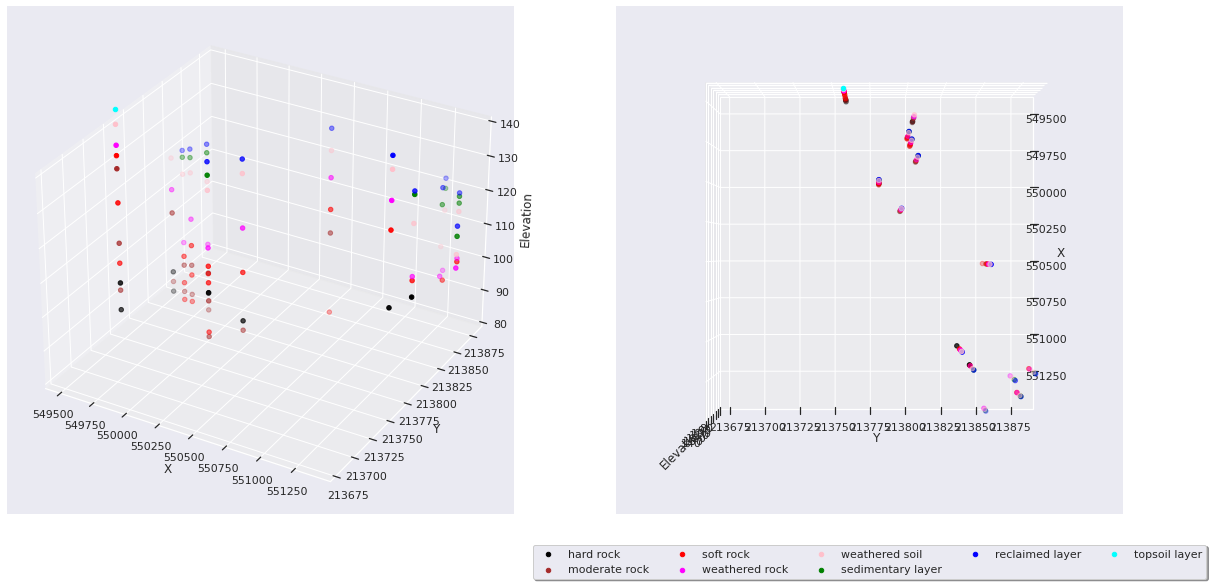

In [43]:
plot_data(X_train_ntb, y_train_ntb, labels, label_colours)
plt.show()

### **TB**

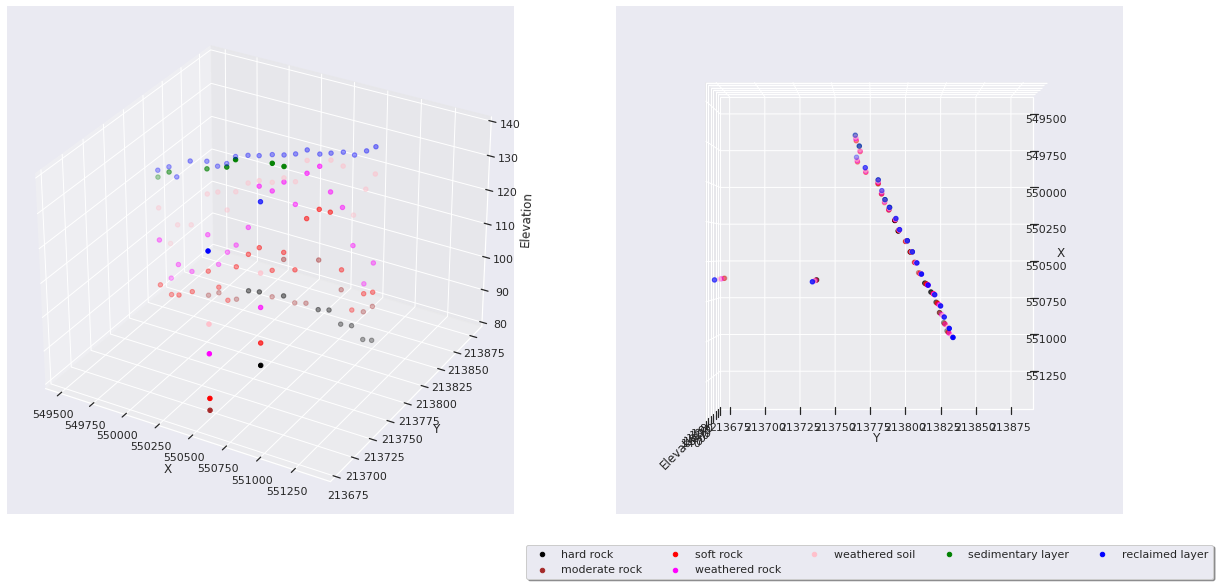

In [44]:
plot_data(X_train_tb, y_train_tb, labels, label_colours)
plt.show()

### **Merged NTB and TB**

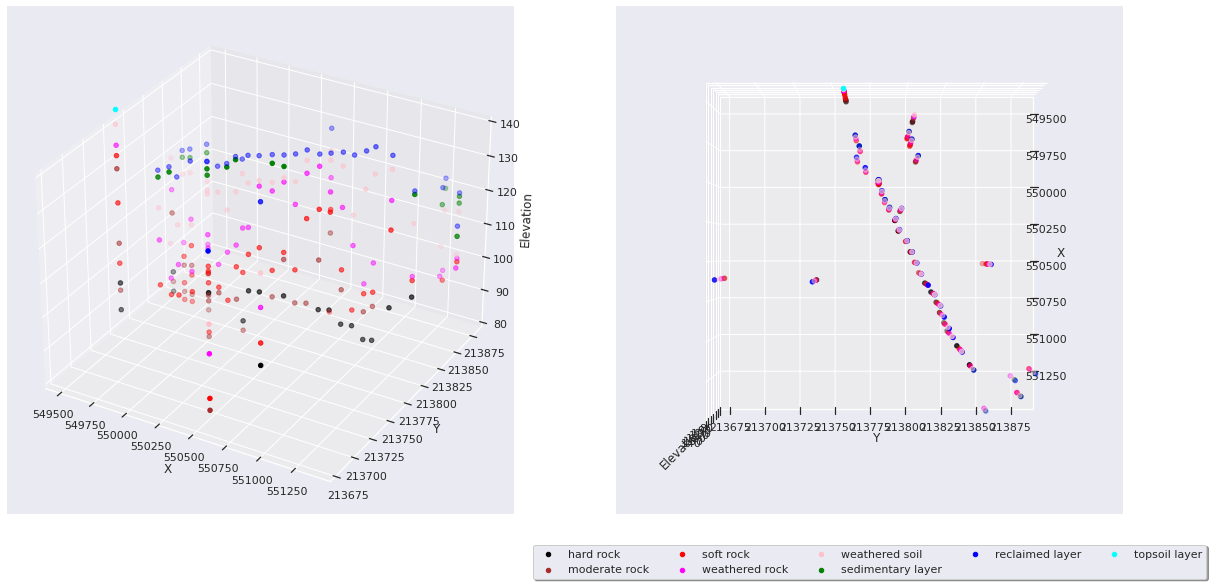

In [45]:
plot_data(X_train_merged_ntb_tb, y_train_merged_ntb_tb, labels, label_colours)
plt.show()

# **Deterministic model results**

## **Train on NTB results**

In [46]:
model_best = get_model_best_epoch(model, model_type = 'deterministic', train_data ='ntb')

In [47]:
y_predict = np.around(model_best.predict(normalized_X_train_ntb)).astype(int)
y_predict[y_predict < 0] = 0
y_predict[y_predict > 7] = 7

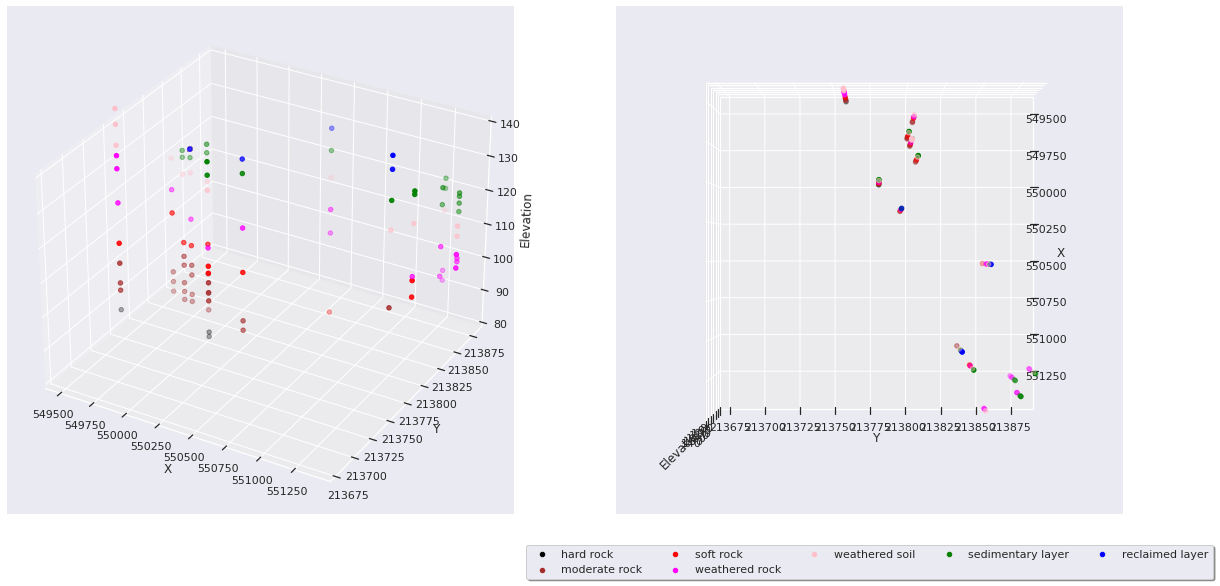

In [48]:
plot_data(X_train_ntb, y_predict, labels, label_colours)
plt.show()

## **Train on TB results**

In [49]:
model_best = get_model_best_epoch(model, model_type = 'deterministic', train_data ='tb')

In [50]:
y_predict = np.around(model_best.predict(normalized_X_train_tb)).astype(int)
y_predict[y_predict < 0] = 0
y_predict[y_predict > 7] = 7

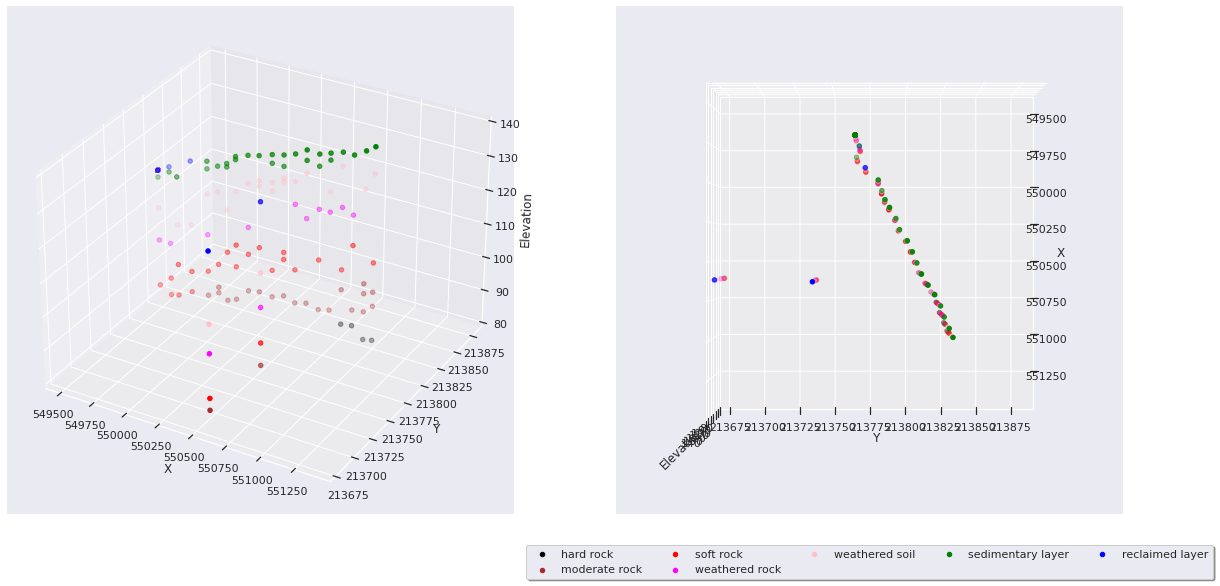

In [51]:
plot_data(X_train_tb, y_predict, labels, label_colours)
plt.show()

## **Train on merged NTB and TB results**

In [52]:
model_best = get_model_best_epoch(model, model_type = 'deterministic', train_data ='merged_ntb_tb')

In [53]:
y_predict = np.around(model_best.predict(normalized_X_merged_ntb_tb)).astype(int)
y_predict[y_predict < 0] = 0
y_predict[y_predict > 7] = 7

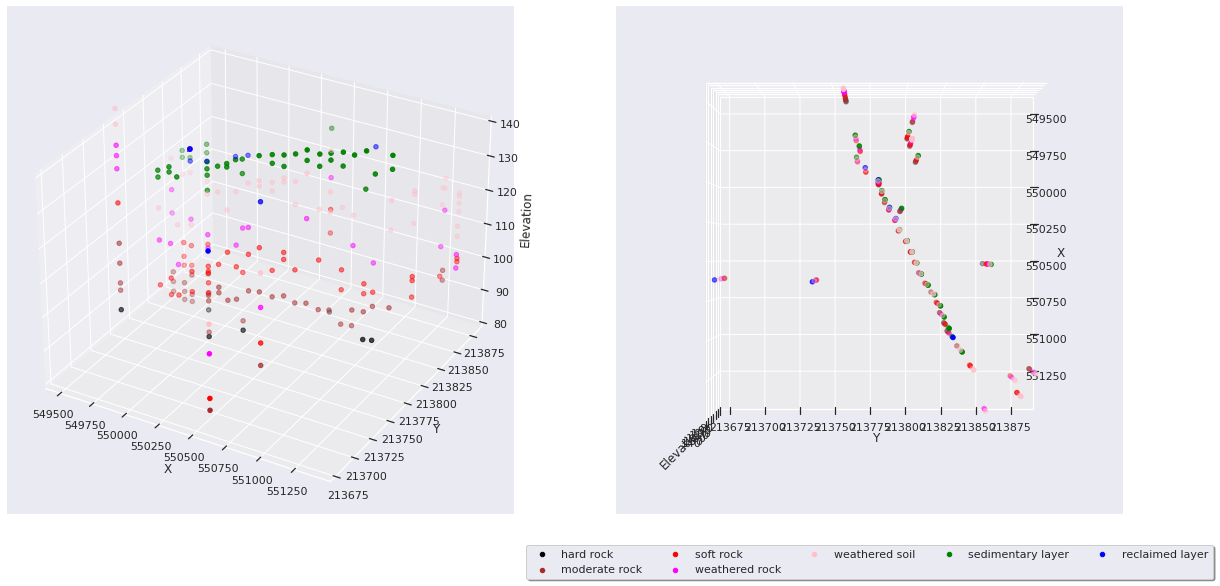

In [54]:
plot_data(X_train_merged_ntb_tb, y_predict, labels, label_colours)
plt.show()

# **Probabilistic model results**

In [55]:
# model_best = get_model_best_epoch(model_prob, model_type = 'probabilistic')
# # model_best = get_model_best_epoch(model, model_type = 'deterministic')

In [56]:
# y_predict = np.around(model_best.predict(normalized_X_train_ntb)).astype(int)
# y_predict[y_predict < 0] = 0
# y_predict[y_predict > 8] = 8

In [57]:
# plot_data(X_train_ntb, y_predict, labels, label_colours)
# plt.show()